NEURAL STYLE TRANSFER USING GAN

project done by Leela Guna Krishna Kompalli

In [41]:
# import necessary libraries

from google.colab import drive

import os
from os import listdir

import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import imageio
import glob

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


In [ ]:
drive.mount('/content/gdrive')
!unzip /content/gdrive/MyDrive/MRI_dataset/MRI+T1_T2+Dataset.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  /content/gdrive/MyDrive/MRI_dataset/MRI+T1_T2+Dataset.zip
replace MRI+T1_T2+Dataset/Tr1/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Data Pre-Processing

In [2]:
def loadImages(path):
  imgs = []
  for img in listdir(path):
    curr_image = load_img(path+img, target_size=(256,256))
    curr_image = img_to_array(curr_image)
    imgs.append(curr_image)
  return np.asarray(imgs)

In [3]:
def convImgTensor(path):
  ds = loadImages(path)
  ds = tf.image.rgb_to_grayscale(ds)
  result = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(ds))
  return result

In [4]:
tr1 = convImgTensor("/content/MRI+T1_T2+Dataset/Tr1/TrainT1/")
tr2 = convImgTensor("/content/MRI+T1_T2+Dataset/Tr2/TrainT2/")

In [5]:
tr2

<TensorSliceDataset shapes: (256, 256, 1), types: tf.float32>

In [6]:
def imagePreprocessing(img):
  img = tf.image.random_flip_left_right(img) # no need to flip vertically
  
  # normalizing
  img =  tf.cast(img, tf.float32)
  img = (img/127.5)-1.0
  return img

In [7]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
tr1 = tr1 .map(imagePreprocessing, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).batch(1)
tr2 = tr2 .map(imagePreprocessing, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).batch(1)

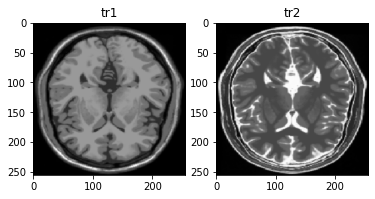

In [8]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

tr1_test = next(iter(tr1))
tr2_test = next(iter(tr2))

titles = ['tr1', 'tr2']
imgs = [tr1_test, tr2_test]

for i in range(len(imgs)):
  plt.subplot(1,2,i+1)
  plt.title(titles[i])
  plt.imshow(imgs[i][0].reshape(256,256), cmap='gray')
plt.show()


Model Building

In [9]:
# MODEL BUILDING

# Instance Normalization

class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    
    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [10]:
# Downsampling

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [11]:
# Upsampling

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

In [30]:
# Using U-Net architecture

def unet_generator():
    down_stack = [
        downsample(64, 4, False), # (bs, 16, 16, 64)
        downsample(128, 4), # (bs, 8, 8, 128)
        downsample(256, 4),  
        downsample(512, 4),  
        downsample(512, 4), 
        downsample(512, 4),  
        downsample(512, 4),  
        downsample(512, 4) 
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),  
        upsample(512, 4, apply_dropout=True),  
        upsample(512, 4, apply_dropout=True),  
        upsample(512, 4),
        upsample(256, 4),   
        upsample(128, 4), # (bs, 8, 8, 256)
        upsample(64, 4) # (bs, 16, 16, 128)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh')
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [31]:
# Initializing generators

generator_g = unet_generator()
generator_f = unet_generator()

In [32]:
generator_g.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
sequential_34 (Sequential)      (None, None, None, 6 1024        input_3[0][0]                    
__________________________________________________________________________________________________
sequential_35 (Sequential)      (None, None, None, 1 131328      sequential_34[0][0]              
__________________________________________________________________________________________________
sequential_36 (Sequential)      (None, None, None, 2 524800      sequential_35[0][0]              
____________________________________________________________________________________________

In [33]:
# Discriminator

def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer
    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    x = inp
    
    # add downsampling step here
    down1 = downsample(64, 4, False)(x) # (bs, 16, 16, 64)
    down2 = downsample(128, 4)(down1) # (bs, 8, 8, 128)
    down3 = downsample(256, 4)(down2)
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    
    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) 
    
    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=inp, outputs=last)

In [16]:
# Initializing discriminators

discriminator_x = discriminator()
discriminator_y = discriminator()

In [17]:
discriminator_x.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, None, None, 1)]   0         
_________________________________________________________________
sequential_28 (Sequential)   (None, None, None, 64)    1024      
_________________________________________________________________
sequential_29 (Sequential)   (None, None, None, 128)   131328    
_________________________________________________________________
sequential_30 (Sequential)   (None, None, None, 256)   524800    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, None, None, 256)   0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, None, 512)   2097152   
_________________________________________________________________
instance_normalization_28 (I (None, None, None, 512)   1024

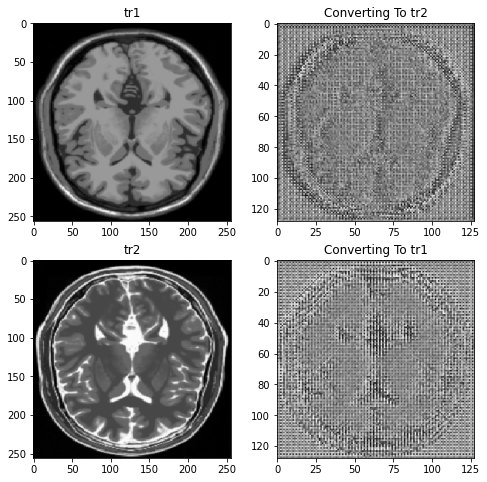

In [18]:
# checking the output of untrained generator

conv2Tr2 = generator_g(tr1_test)
conv2Tr1 = generator_f(tr2_test)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [tr1_test, conv2Tr2, tr2_test, conv2Tr1]
title = ['tr1', 'Converting To tr2', 'tr2', 'Converting To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0].numpy()[:, :, 0], cmap='gray')
plt.show()

In [19]:
# Declaring loss as a binary cross entropy

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
# Defining Discriminator loss

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5 # mean of losses

In [21]:
# Defining generator loss

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [22]:
# calculating cycle loss

def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss1

In [23]:
# calculating identity loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5*loss

In [24]:
# Initializing optimizers

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [25]:
EPOCHS = 10

In [35]:
checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [34]:
def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(8, 4))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

Training Initialization

In [36]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

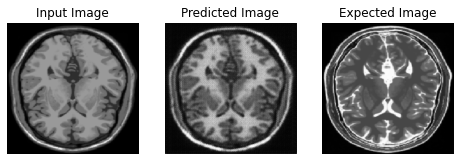

Saving checkpoint for epoch 1 at ./Trained_Model/ckpt-1


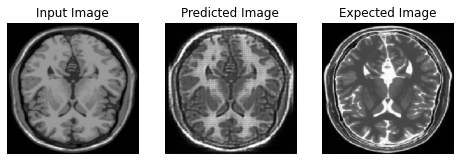

Saving checkpoint for epoch 2 at ./Trained_Model/ckpt-2


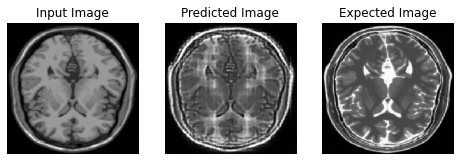

Saving checkpoint for epoch 3 at ./Trained_Model/ckpt-3


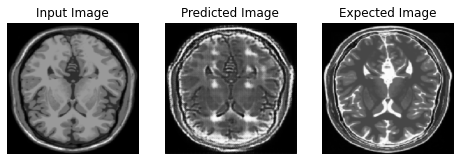

Saving checkpoint for epoch 4 at ./Trained_Model/ckpt-4


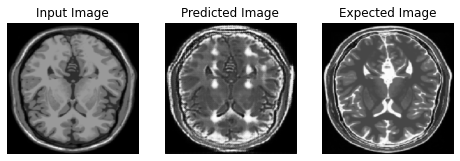

Saving checkpoint for epoch 5 at ./Trained_Model/ckpt-5


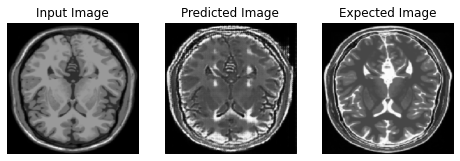

Saving checkpoint for epoch 6 at ./Trained_Model/ckpt-6


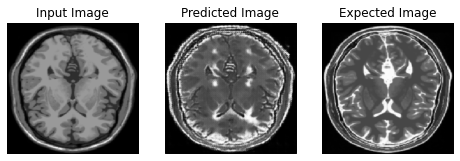

Saving checkpoint for epoch 7 at ./Trained_Model/ckpt-7


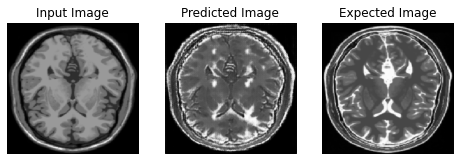

Saving checkpoint for epoch 8 at ./Trained_Model/ckpt-8


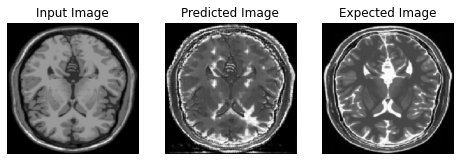

Saving checkpoint for epoch 9 at ./Trained_Model/ckpt-9


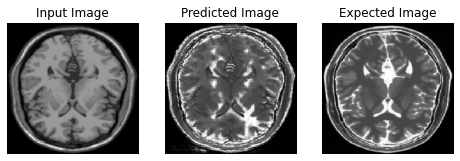

Saving checkpoint for epoch 10 at ./Trained_Model/ckpt-10


In [37]:
tf.config.run_functions_eagerly(True)

for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        train_step(image_x, image_y)
    generate_images(generator_g, tr1_test, tr2_test)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

In [42]:
anim_file = 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [43]:
pip install git+https://github.com/tensorflow/docs

n
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-lsyh6lo_
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-lsyh6lo_
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=157746 sha256=2d7d0bf0e6553e693c98f561470098ee041a9ff770f2c82c4a7323106b266a6e
  Stored in directory: /tmp/pip-ephem-wheel-cache-3s1gip0n/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs



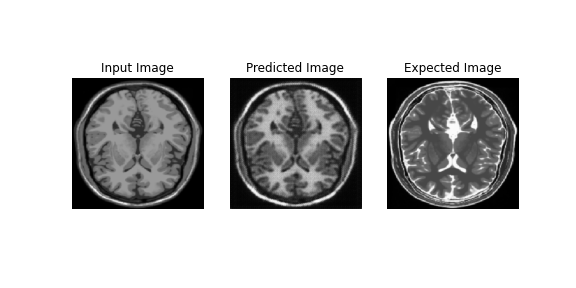

In [44]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)